## 0 - Set-up
Like in R Markdown, there can be multiple chunks of text and code. First, we begin with importing the necessary tools from relevant libraries.

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

from sklearn.linear_model import LogisticRegression

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('ggplot')

## 1 - Exploratory Data Analysis

In machine learning, it is common for the data to be high-dimensional and not very interpretable. It would be a good idea to familiarize ourselves with the dataset before continuing our analysis.

#### 1.1 - Loading the data

In this tutorial, we are interested in the MNIST handwritten digits dataset. Luckily for us, this dataset is one of the benchmark datasets widely used in the machine learning literature, so it is readily available in packages. More information about this database available on its [Wikipedia](https://en.wikipedia.org/wiki/MNIST_database) page and [here](http://yann.lecun.com/exdb/mnist/).

In [15]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#### 1.2 - Visualizing the data

In [18]:
index = 1234 # between 0 and 60000

Number label: 3


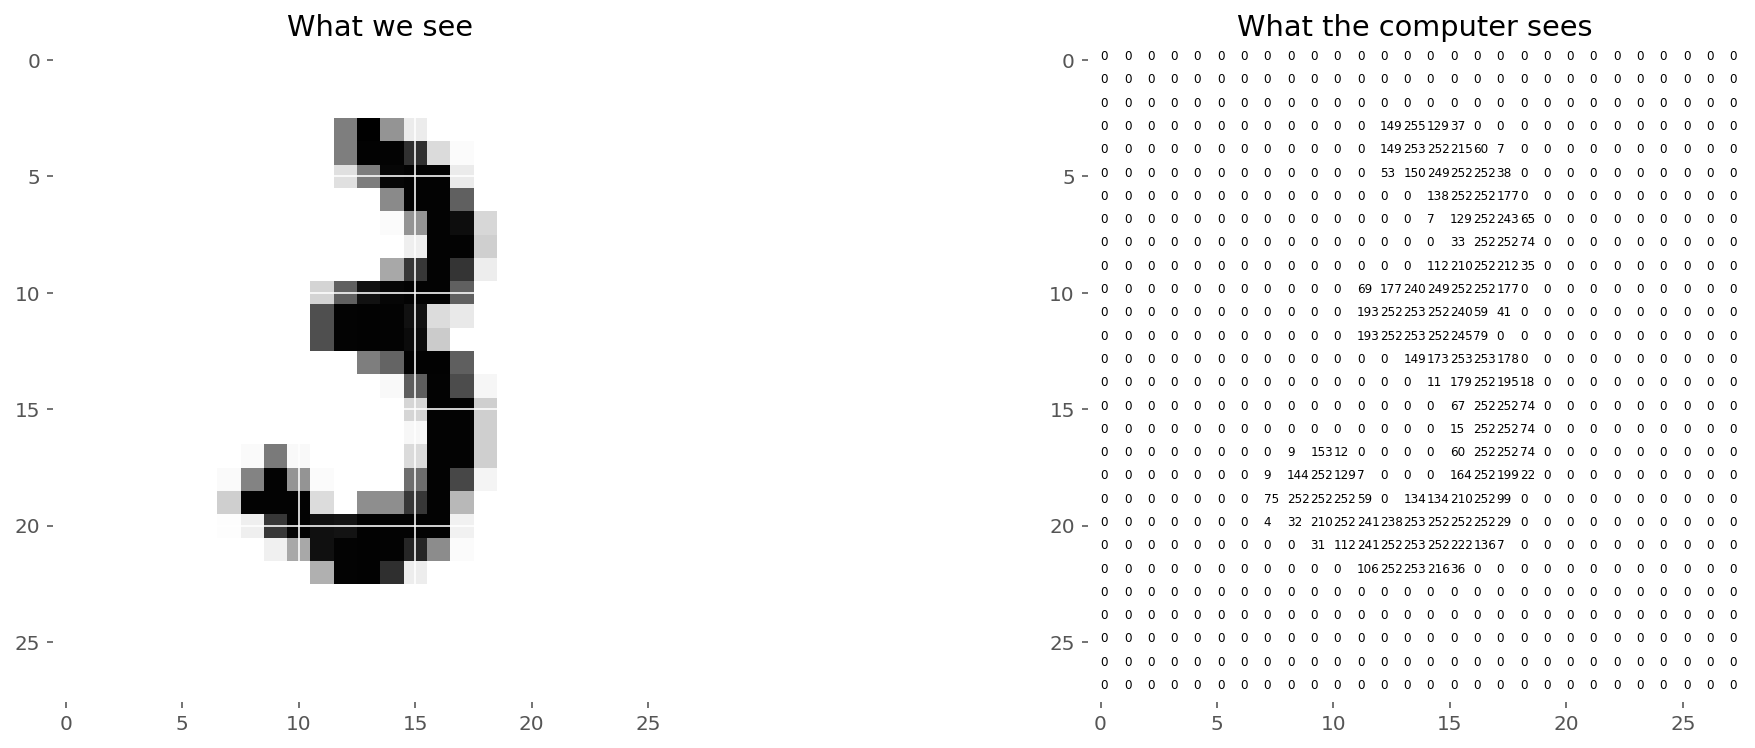

In [24]:
print('Number label: ' + str(y_train[index]))
fig = plt.figure(figsize=(17, 6))
ax1 = fig.add_subplot(121)
ax1 = plt.imshow(x_train[index], cmap='Greys')
ax1 = plt.title('What we see')
ax2 = fig.add_subplot(122)
ax2 = plt.imshow(np.zeros_like(x_train[index]), cmap='Greys')
for i in range(28):
    for j in range(28):
        digit = x_train[index][i][j]
        ax2 = plt.text(j, i, x_train[index][i][j], fontsize=6)
ax2 = plt.title('What the computer sees')

###### 1.1.1 - Why are there multiple Python packages for machine learning? Don't they do the same thing?

There are multiple open-source packages that allow users to build complex neural network models. Today, three of them are most widely used:
- Tensorflow
- Pytorch
- Keras
In this exercise, we will be using Keras due to its simplicity in implementation. On top of being well-maintained, each package has their own documentation and tutorials on how to use them.

###### 1.1.2 - What is the difference between the train and test dataset?

#### 1.3 - Verifying how the data is encoded

In [28]:
print(x_train.shape)
print(x_train[index].shape)

(60000, 28, 28)
(28, 28)


The entire dataset is encoded as a 3-dimensional matrix. In other words, you can think of it as a vector of matrices:
\begin{align*}
    \texttt{x_train} = \left[\text{digit}_1, \text{digit}_2, \dots, \text{digit}_{60\,000}\right]
\end{align*}
where $\text{digit}_i$ is itself a $(28 \times 28)$ matrix (see below) where $i$ is any index between $1$ and $60\,000$.

In [27]:
print(x_train[index])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 149 255 129  37   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 149 253 252 215  60   7
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  53 150 249 252 252  38
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 138 252 252 177
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   7 129 252 243
   65   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  3

###### What if our pictures were in colour?

## 2 - Classification
#### 2.1 - Brainstorm
Before jumping right into neural networks... what are we trying to do? Let us think about the classification task from different perspectives:
- Intuition
- Statistical
- Implementation
- Computational

#### 2.2 - Data pre-processing
In general, the data at hand are often messy: formatting difficult to be understood, data encoding not adequate for available tools, etc. In many cases, a good portion of the data analyses is spent on data pre-processing.

In [4]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train.astype(float)
x_test  = x_test.reshape(-1, 28, 28, 1)
x_test  = x_test.astype(float)

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test  = keras.utils.to_categorical(y_test, num_classes=10)

```x_train[1234]:```
$$
\begin{bmatrix}
    0 & 0 & 0 & 0 &\dots\\
    0 & 0 & 149 & 255 & \dots\\
    0 & 0 & 149 & 253 & \dots \\
    0 & 0 & 53 & 150  & \dots\\
    0 & 0 & 0  & 138 & \dots\\
    \vdots & \vdots & \vdots &\vdots & \ddots
\end{bmatrix}_{\,(28 \times 28)} \rightarrow
\begin{bmatrix}
    [0] & [0] & [0] & [0] &\dots\\
    [0] & [0] & [149] & [255] & \dots\\
    [0] & [0] & [149] & [253] & \dots \\
    [0] & [0] & [53] & [150]  & \dots\\
    [0] & [0] & [0]  & [138] & \dots\\
    \vdots & \vdots & \vdots &\vdots & \ddots
\end{bmatrix}_{\,(28 \times 28 \times 1)}$$

```y_train[1234]:```
$$3 \rightarrow \left[0, 0, 0, 1, 0, 0, 0, 0, 0, 0\right]$$

###### Data can be much more complexe...
Voice, image data.

## 3 - Model Implementation

#### 3.1 - What is our model?

In this tutorial, we will be using one of the simplest yet fundamental neural network structures commonly used in machine learning: multilayer perceptron (MLP).

#### 3.2 - Building our Keras model

In [29]:
model = Sequential()
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

##### What does each line mean?
```model = Sequential()``` &rarr; Model initialization

```model.add(Flatten())``` &rarr; We're "flattening" the images for our multilayer perceptron

```model.add(Dense(128, activation='relu'))``` &rarr; We're adding one layer of hidden units with 128 nodes/"neurons"

```model.add(Dense(10, activation='softmax'))``` &rarr;

## 1 - Exploratory Analysis
Generally, with neural networks and many inference procedures under the machine learning umbrella, data is less "pretty". In other words:
- No distribution is posited for the data at hand
- Data can be much more complex (e.g. images, voice recordings, etc.) and no inherent distribution is assumed (contrary to linear and logistic regression)

#### Pros
- Much more flexibility in noisyness of data: neural networks do not assume any structure on the data-generating mechanism or any inherent distributions from which stems the data at hand.
- Neural networks can learn complex and non-linear functions (c.f. Universal Approximation Theorem).
- Data can come in all shapes and forms!

#### Limitations
- Value and number of hyperparameters?
- Theoretical guarantees?
- Overfitting

In [13]:
lr_model = LogisticRegression(multi_class='multinomial') # cannot name lr.model
lr_model.fit(x_train.reshape(-1, 28*28), y_train)

/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: bad input shape (60000, 10)

### Building the ```Keras``` model

In [5]:
model = Sequential()
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

W0921 04:07:24.727822 4741756352 deprecation.py:506] From /anaconda3/envs/ml/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
model.compile(optimizer='adam', 
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
model.fit(x=x_train,
          y=y_train, 
          epochs=5)

Epoch 1/5
60000/60000 [==============================] - 9s 156us/sample - loss: 2.4181 - acc: 0.8580
Epoch 2/5
60000/60000 [==============================] - 9s 145us/sample - loss: 0.3686 - acc: 0.9111
Epoch 3/5
25504/60000 [===========>..................] - ETA: 5s - loss: 0.2795 - acc: 0.9283

KeyboardInterrupt: 

#### Are neural networks good models?

In [ ]:
predictions = np.argmax(model.predict(x_train), axis=1)